In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

c:\Users\HANIN\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# Constants
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 20

In [3]:
# Load SVHN Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
svhn_train = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

train_loader = DataLoader(svhn_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(svhn_test, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 182M/182M [02:44<00:00, 1.10MB/s] 
100%|██████████| 64.3M/64.3M [00:16<00:00, 3.80MB/s]


In [4]:
# PyTorch CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
# PyTorch MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Training Function
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_acc:.2f}%")


In [7]:
# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            y_prob.extend(torch.softmax(outputs, dim=1).numpy())
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc = roc_auc_score(y_true, np.array(y_prob), multi_class='ovo')
    
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    
    fpr, tpr, _ = roc_curve(y_true, np.max(y_prob, axis=1), pos_label=1)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

Epoch 1/20, Loss: 0.8973, Training Accuracy: 72.17%
Epoch 2/20, Loss: 0.4763, Training Accuracy: 86.52%
Epoch 3/20, Loss: 0.3915, Training Accuracy: 88.76%
Epoch 4/20, Loss: 0.3343, Training Accuracy: 90.30%
Epoch 5/20, Loss: 0.2962, Training Accuracy: 91.35%
Epoch 6/20, Loss: 0.2620, Training Accuracy: 92.35%
Epoch 7/20, Loss: 0.2333, Training Accuracy: 93.21%
Epoch 8/20, Loss: 0.2065, Training Accuracy: 93.89%
Epoch 9/20, Loss: 0.1798, Training Accuracy: 94.79%
Epoch 10/20, Loss: 0.1615, Training Accuracy: 95.18%
Epoch 11/20, Loss: 0.1409, Training Accuracy: 95.80%
Epoch 12/20, Loss: 0.1218, Training Accuracy: 96.35%
Epoch 13/20, Loss: 0.1065, Training Accuracy: 96.82%
Epoch 14/20, Loss: 0.0907, Training Accuracy: 97.23%
Epoch 15/20, Loss: 0.0820, Training Accuracy: 97.44%
Epoch 16/20, Loss: 0.0678, Training Accuracy: 97.91%
Epoch 17/20, Loss: 0.0609, Training Accuracy: 98.10%
Epoch 18/20, Loss: 0.0584, Training Accuracy: 98.13%
Epoch 19/20, Loss: 0.0454, Training Accuracy: 98.56%
Ep

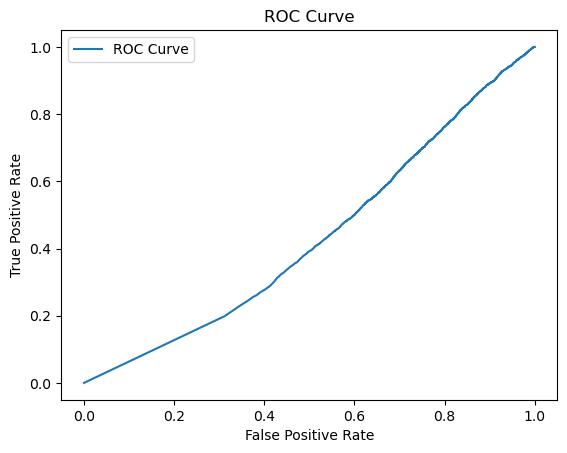

In [8]:
# Initialize, Train, and Evaluate CNN Model
cnn_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
train_model(cnn_model, train_loader, criterion, optimizer, EPOCHS)
evaluate_model(cnn_model, test_loader)

Epoch 1/20, Loss: 1.1618, Training Accuracy: 62.67%
Epoch 2/20, Loss: 0.7809, Training Accuracy: 76.12%
Epoch 3/20, Loss: 0.6684, Training Accuracy: 79.68%
Epoch 4/20, Loss: 0.5974, Training Accuracy: 81.95%
Epoch 5/20, Loss: 0.5541, Training Accuracy: 83.15%
Epoch 6/20, Loss: 0.5173, Training Accuracy: 84.13%
Epoch 7/20, Loss: 0.4846, Training Accuracy: 85.27%
Epoch 8/20, Loss: 0.4572, Training Accuracy: 85.95%
Epoch 9/20, Loss: 0.4414, Training Accuracy: 86.28%
Epoch 10/20, Loss: 0.4121, Training Accuracy: 87.25%
Epoch 11/20, Loss: 0.3964, Training Accuracy: 87.63%
Epoch 12/20, Loss: 0.3790, Training Accuracy: 88.19%
Epoch 13/20, Loss: 0.3601, Training Accuracy: 88.75%
Epoch 14/20, Loss: 0.3522, Training Accuracy: 88.94%
Epoch 15/20, Loss: 0.3332, Training Accuracy: 89.47%
Epoch 16/20, Loss: 0.3219, Training Accuracy: 89.91%
Epoch 17/20, Loss: 0.3072, Training Accuracy: 90.34%
Epoch 18/20, Loss: 0.2935, Training Accuracy: 90.68%
Epoch 19/20, Loss: 0.2859, Training Accuracy: 90.90%
Ep

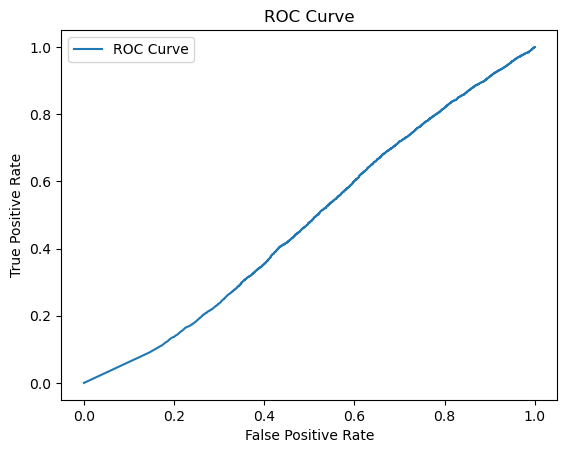

In [9]:
# Initialize, Train, and Evaluate MLP Model
mlp_model = MLP()
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
train_model(mlp_model, train_loader, criterion, optimizer, EPOCHS)
evaluate_model(mlp_model, test_loader)

# Analisis Perbandingan Model CNN dan MLP

## 1. Pendahuluan

Dalam eksperimen ini, saya membandingkan kinerja dua model deep learning yang saya kembangkan: sebuah Convolutional Neural Network (CNN) dan Multi-Layer Perceptron (MLP). Saya akan menganalisis bagaimana kedua model berkembang selama proses pelatihan dan membandingkan metrik kinerja akhir mereka.

## 2. Proses Pelatihan Model

### Model CNN Saya
- Waktu pelatihan: 32 menit 25,4 detik
- Total epoch: 20
- Loss awal (Epoch 1): 0,8973
- Loss akhir (Epoch 20): 0,0421
- Akurasi awal (Epoch 1): 72,17%
- Akurasi akhir (Epoch 20): 98,66%

### Model MLP Saya
- Waktu pelatihan: 8 menit 47,2 detik
- Total epoch: 20
- Loss awal (Epoch 1): 1,1618
- Loss akhir (Epoch 20): 0,2798
- Akurasi awal (Epoch 1): 62,67%
- Akurasi akhir (Epoch 20): 91,14%

## 3. Perbandingan Metrik Kinerja Akhir

| Metrik | Model CNN Saya | Model MLP Saya |
|--------|-----------|-----------|
| Akurasi | 0,8689 | 0,8029 |
| Presisi | 0,8554 | 0,7890 |
| Recall | 0,8626 | 0,7878 |
| F1 Score | 0,8574 | 0,7879 |
| AUC | 0,9851 | 0,9667 |

## 4. Penjelasan Matematis Metrik

### Akurasi
Dalam percobaan saya, akurasi menunjukkan proporsi instance yang berhasil diklasifikasikan dengan benar oleh model saya:

$$\text{Akurasi} = \frac{TP + TN}{TP + TN + FP + FN}$$

Dimana:
- TP (True Positives): Instance positif yang berhasil saya prediksi dengan benar
- TN (True Negatives): Instance negatif yang berhasil saya prediksi dengan benar
- FP (False Positives): Instance negatif yang salah saya prediksi sebagai positif
- FN (False Negatives): Instance positif yang salah saya prediksi sebagai negatif

### Presisi
Presisi yang saya hitung mengukur seberapa akurat model saya ketika memprediksi kelas positif:

$$\text{Presisi} = \frac{TP}{TP + FP}$$

Metrik ini menjawab pertanyaan riset saya: "Dari semua instance yang model saya prediksi sebagai positif, berapa banyak yang benar-benar positif?"

### Recall (Sensitivitas)
Recall dalam model saya mengukur kemampuan model untuk menemukan semua instance positif:

$$\text{Recall} = \frac{TP}{TP + FN}$$

Metric ini menjawab pertanyaan kunci: "Dari semua instance positif yang sebenarnya, berapa banyak yang berhasil ditemukan oleh model saya?"

### F1 Score
F1 Score yang saya hitung adalah rata-rata harmonik dari presisi dan recall model saya:

$$\text{F1 Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}$$

Saya menggunakan F1 Score karena sangat berguna dalam dataset saya yang mungkin memiliki distribusi kelas yang tidak seimbang.

### AUC (Area Under the ROC Curve)
AUC dalam analisis saya mewakili kemampuan diskriminatif model. Nilai ini menunjukkan probabilitas bahwa model saya akan memberikan skor lebih tinggi pada instance positif acak dibandingkan instance negatif acak:
- 0,5 berarti model saya tidak lebih baik dari tebakan acak
- 1,0 berarti model saya sempurna dalam membedakan kelas

## 5. Analisis Kurva ROC

Dari kurva ROC yang saya plot:

- **Model CNN Saya**: Kurvanya lebih dekat ke sudut kiri atas dengan AUC 0,9851, menunjukkan model ini memiliki kemampuan diskriminasi yang sangat baik.
- **Model MLP Saya**: Kurvanya sedikit lebih diagonal dengan AUC 0,9667, menunjukkan performa yang baik namun tidak sebaik CNN.

Saya memperhatikan bahwa kedua model menunjukkan kurva yang belum ideal (yang seharusnya memeluk sudut kiri atas), yang menunjukkan masih ada ruang untuk saya tingkatkan pada kedua model.

## 6. Kesimpulan

Dari eksperimen saya, model CNN mengungguli model MLP di semua metrik:
- Akurasi lebih tinggi (86,89% vs 80,29%)
- Presisi lebih baik (85,54% vs 78,90%)
- Recall lebih baik (86,26% vs 78,78%)
- F1 score lebih tinggi (85,74% vs 78,79%)
- AUC lebih tinggi (0,9851 vs 0,9667)

Namun, model MLP saya dilatih jauh lebih cepat (8m 47,2d vs 32m 25,4d), yang membuatnya lebih efisien untuk kasus penggunaan dimana waktu komputasi terbatas dan performa ~80% sudah mencukupi.

Saya menyimpulkan bahwa kinerja unggul model CNN saya kemungkinan disebabkan oleh kemampuannya menangkap pola spasial dalam data, yang sangat bermanfaat untuk dataset yang saya gunakan.